In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import skimage.exposure
import skimage.io
import skimage.transform
import sklearn.model_selection
import sklearn.metrics
import sklearn.svm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skimage.feature import hog
from skimage.util import random_noise
from skimage.filters import gaussian

import random

In [2]:
path_train = r'dataset/train'
path_valid = r'dataset/valid'

label_ref = {
    'black widow': 0,
    'captain america': 1,
    'doctor strange': 2,
    'hulk': 3,
    'ironman': 4,
    'loki': 5,
    'spider-man': 6,
    'thanos': 7
}

In [3]:
def get_img_cls(data_path):
    pic_labels = {}

    for hero in os.listdir(data_path):
        for pic in os.listdir(f'{data_path}/{hero}'):
            pic_labels[f'{data_path}/{hero}/{pic}'] = label_ref[hero]

    return pic_labels

In [4]:
hog_img_size = (128,64)
hog_orientations = 8
hog_pixels_per_cell = (16, 16)
hog_cells_per_block = (1, 1)
hog_channel_axis = -1

def get_hog(resized_image):
    return skimage.feature.hog(resized_image,
                              orientations=hog_orientations,
                              pixels_per_cell=hog_pixels_per_cell,
                              cells_per_block=hog_cells_per_block,
                              channel_axis=hog_channel_axis)

In [5]:
train_img_cls = get_img_cls(path_train)

X_list = []
y_list = []

for img in train_img_cls.keys():
    img_data = skimage.io.imread(img)
    resized_img = skimage.transform.resize(img_data, hog_img_size)
    X_list.append(get_hog(resized_img))
    y_list.append(train_img_cls[img])

X = np.vstack(X_list)
y = np.array(y_list)

# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=10)

In [6]:
print(X.shape, y.shape)

(2584, 256) (2584,)


In [6]:
svm_C = 9
svm_gamma = 0.4 # rbf, poly, sigmoid
svm_kernel = 'rbf'
svm_degree = 3 # poly
svm_coef = 0 # poly, sigmoid
svm_decision = 'ovr'
svm_shrink = True

svm_model = sklearn.svm.SVC(C=svm_C,
                            gamma=svm_gamma, #
                            kernel=svm_kernel,
                            coef0=svm_coef,
                            decision_function_shape=svm_decision,
                            shrinking=svm_shrink,
                            verbose=True)
svm_model.fit(X, y)


[LibSVM]

SVC(C=9, coef0=0, gamma=0.4, verbose=True)

In [7]:
valid_img_cls = get_img_cls(path_valid)

valid_X_list = []
valid_y_list = []

for img in valid_img_cls.keys():
    img_data = skimage.io.imread(img)
    resized_img = skimage.transform.resize(img_data, hog_img_size)
    valid_X_list.append(get_hog(resized_img))
    valid_y_list.append(valid_img_cls[img])

X_valid = np.vstack(valid_X_list)
y_valid = np.array(valid_y_list)

y_pred = svm_model.predict(X_valid)
sklearn.metrics.accuracy_score(y_valid, y_pred)

0.2616407982261641

In [9]:
'''
hog_img_size = (128, 64)
hog_orientations = 8
hog_pixels_per_cell = (16, 16)
hog_cells_per_block = (1, 1)
hog_channel_axis = -1

svm_C = 9
svm_gamma = 0.4
svm_kernal = 'rbf'
svm_degree = 3
svm_coef = 0
svm_decision = 'ovr'

0.2616407982261641
'''

"\nhog_img_size = (128, 64)\nhog_orientations = 8\nhog_pixels_per_cell = (16, 16)\nhog_cells_per_block = (1, 1)\nhog_channel_axis = -1\n\nsvm_C = 9\nsvm_gamma = 0.4\nsvm_kernal = 'rbf'\nsvm_degree = 3\nsvm_coef = 0\nsvm_decision = 'ovr'\n\n0.2616407982261641\n"

[LibSVM]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


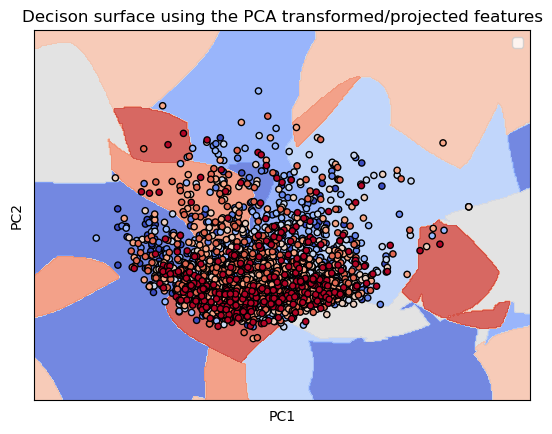

In [10]:
# modified from https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = sklearn.svm.SVC(C=svm_C,
                        gamma=svm_gamma, #
                        kernel=svm_kernel,
                        coef0=svm_coef,
                        decision_function_shape=svm_decision,
                        shrinking=svm_shrink,
                        verbose=True)
clf = model.fit(Xreduced, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.savefig('decision_boundry.jpg')
plt.show()

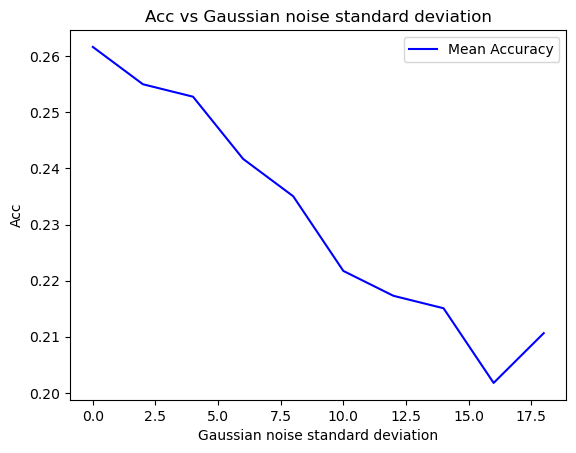

In [11]:
#Test the accuracy with test data after adding gaussian pixel noise

acc_gau = []

stds = [0,2,4,6,8,10,12,14,16,18]

for std in stds:
    
    valid_X_list = []
    valid_y_list = []

    for img in valid_img_cls.keys():
        img_data = skimage.io.imread(img)

        # add gaussian noise
        img_gau = random_noise(img_data, mode='gaussian', mean = 0, var = (std/255)**2, clip=True)
        
        resized_img = skimage.transform.resize(img_gau*255, hog_img_size)
        valid_X_list.append(get_hog(resized_img))
        valid_y_list.append(valid_img_cls[img])

    X_valid = np.vstack(valid_X_list)
    y_valid = np.array(valid_y_list)

    y_pred = svm_model.predict(X_valid)
    acc_gau.append(sklearn.metrics.accuracy_score(y_valid, y_pred))

plt.figure(1)
plt.title("Acc vs Gaussian noise standard deviation")
plt.xlabel('Gaussian noise standard deviation')
plt.ylabel('Acc')
plt.plot(stds,acc_gau,color = 'b', label="Mean Accuracy")
plt.legend()
plt.savefig('svm_gau.jpg')
plt.show()

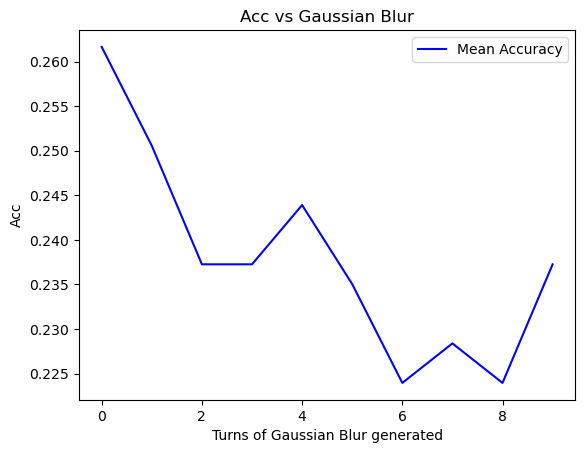

In [8]:
#Test the accuracy with test data after adding gaussian blur
acc_blur = []

turns = range(10)

for t in turns:
    
    valid_X_list = []
    valid_y_list = []

    for img in valid_img_cls.keys():
        img_data = skimage.io.imread(img)

        for i in range(t):
           img_data = cv2.GaussianBlur(img_data,(3,3),cv2.BORDER_DEFAULT)

        resized_img = skimage.transform.resize(img_data, hog_img_size)
        valid_X_list.append(get_hog(resized_img))
        valid_y_list.append(valid_img_cls[img])

    X_valid = np.vstack(valid_X_list)
    y_valid = np.array(valid_y_list)

    y_pred = svm_model.predict(X_valid)
    acc_blur.append(sklearn.metrics.accuracy_score(y_valid, y_pred))

plt.figure(1)
plt.title("Acc vs Gaussian Blur")
plt.xlabel('Turns of Gaussian Blur generated')
plt.ylabel('Acc')
plt.plot(turns,acc_blur,color = 'b', label="Mean Accuracy")
plt.legend()
plt.savefig('svm_gau_blur.jpg')
plt.show()

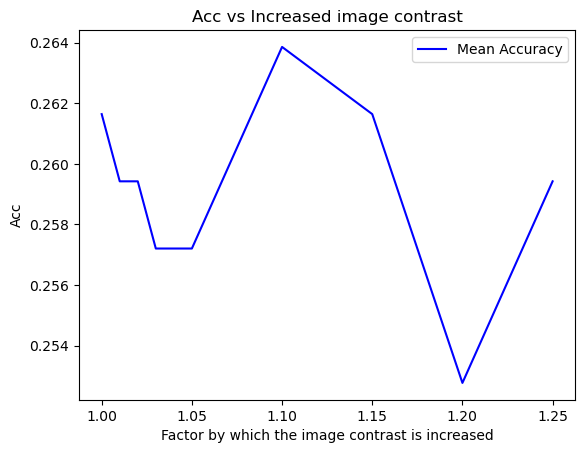

In [13]:
#Test the accuracy with test data after increasing the image contrast
acc_contrast = []

factors = [1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.1, 1.15, 1.20, 1.25]

for f in factors:
    
    valid_X_list = []
    valid_y_list = []

    for img in valid_img_cls.keys():
        img_data = skimage.io.imread(img)
        
        img_val = (img_data).astype(np.uint16)
        img_val_in = np.clip(img_val * f, 0, 255)

        resized_img = skimage.transform.resize(img_val_in, hog_img_size)
        valid_X_list.append(get_hog(resized_img))
        valid_y_list.append(valid_img_cls[img])

    X_valid = np.vstack(valid_X_list)
    y_valid = np.array(valid_y_list)

    y_pred = svm_model.predict(X_valid)
    acc_contrast.append(sklearn.metrics.accuracy_score(y_valid, y_pred))

plt.figure(1)
plt.title("Acc vs Increased image contrast")
plt.xlabel('Factor by which the image contrast is increased')
plt.ylabel('Acc')
plt.plot(factors,acc_contrast,color = 'b', label="Mean Accuracy")
plt.legend()
plt.savefig('svm_contrast_in.jpg')
plt.show()

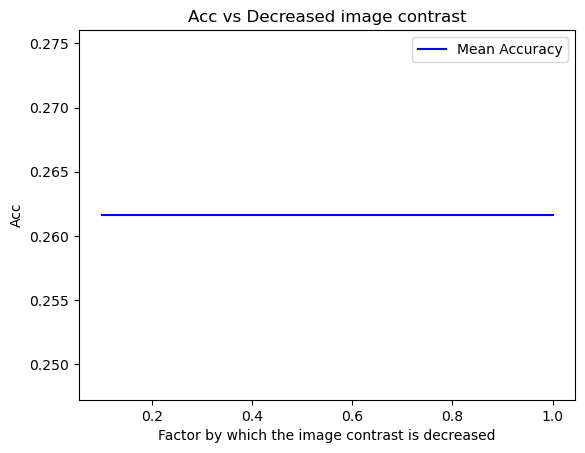

In [25]:
#Test the accuracy with test data after decreasing the image contrast
acc_contrast_de = []

factors_de = [1.0, 0.95, 0.90, 0.85, 0.80, 0.60, 0.40, 0.30, 0.20, 0.10]

for f in factors_de:
    
    valid_X_list = []
    valid_y_list = []

    for img in valid_img_cls.keys():
        img_data = skimage.io.imread(img)
        
        img_val = (img_data).astype(np.uint16)
        img_val_in = np.clip(img_val * f, 0, 255)

        resized_img = skimage.transform.resize(img_val_in, hog_img_size)
        valid_X_list.append(get_hog(resized_img))
        valid_y_list.append(valid_img_cls[img])

    X_valid = np.vstack(valid_X_list)
    y_valid = np.array(valid_y_list)

    y_pred = svm_model.predict(X_valid)
    acc_contrast_de.append(sklearn.metrics.accuracy_score(y_valid, y_pred))

plt.figure(1)
plt.title("Acc vs Decreased image contrast")
plt.xlabel('Factor by which the image contrast is decreased')
plt.ylabel('Acc')
plt.plot(factors_de,acc_contrast_de,color = 'b', label="Mean Accuracy")
plt.legend()
plt.savefig('svm_contrast_de.jpg')
plt.show()

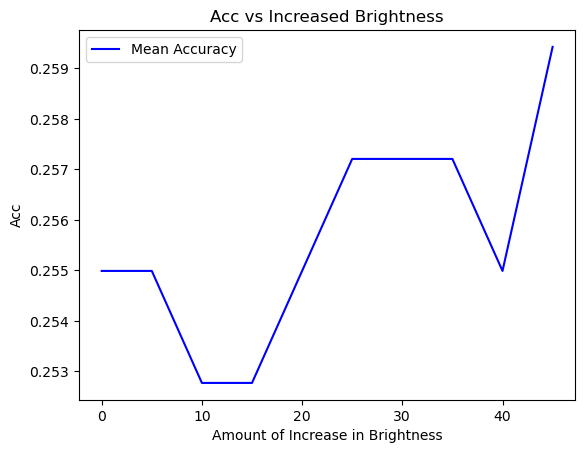

In [23]:
#Test the accuracy with test data after increasing the image brightness
acc_bright = []

bright_change = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

for b in bright_change:
    
    valid_X_list = []
    valid_y_list = []

    for img in valid_img_cls.keys():
        img_data = skimage.io.imread(img)
        
        img_val = (img_data).astype(np.uint16)
        img_val_in = np.clip(img_val + b, 0, 255)

        resized_img = skimage.transform.resize(img_val_in, hog_img_size)
        valid_X_list.append(get_hog(resized_img))
        valid_y_list.append(valid_img_cls[img])

    X_valid = np.vstack(valid_X_list)
    y_valid = np.array(valid_y_list)

    y_pred = svm_model.predict(X_valid)
    acc_bright.append(sklearn.metrics.accuracy_score(y_valid, y_pred))

plt.figure(1)
plt.title("Acc vs Increased Brightness")
plt.xlabel('Amount of Increase in Brightness')
plt.ylabel('Acc')
plt.plot(bright_change, acc_bright, color = 'b', label="Mean Accuracy")
plt.legend()
plt.savefig('svm_bright_in.jpg')
plt.show()

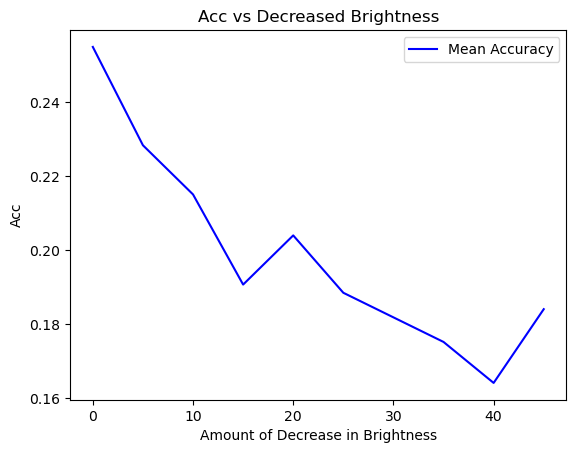

In [16]:
#Test the accuracy with test data after decreasing the image brightness
acc_bright_de = []

bright_change = [ 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

for b in bright_change:
    
    valid_X_list = []
    valid_y_list = []

    for img in valid_img_cls.keys():
        img_data = skimage.io.imread(img)
        
        img_val = (img_data).astype(np.uint16)
        img_val_in = np.clip(img_val - b, 0, 255)

        resized_img = skimage.transform.resize(img_val_in, hog_img_size)
        valid_X_list.append(get_hog(resized_img))
        valid_y_list.append(valid_img_cls[img])

    X_valid = np.vstack(valid_X_list)
    y_valid = np.array(valid_y_list)

    y_pred = svm_model.predict(X_valid)
    acc_bright_de.append(sklearn.metrics.accuracy_score(y_valid, y_pred))

plt.figure(1)
plt.title("Acc vs Decreased Brightness")
plt.xlabel('Amount of Decrease in Brightness')
plt.ylabel('Acc')
plt.plot(bright_change, acc_bright_de, color = 'b', label="Mean Accuracy")
plt.legend()
plt.savefig('svm_bright_de.jpg')
plt.show()

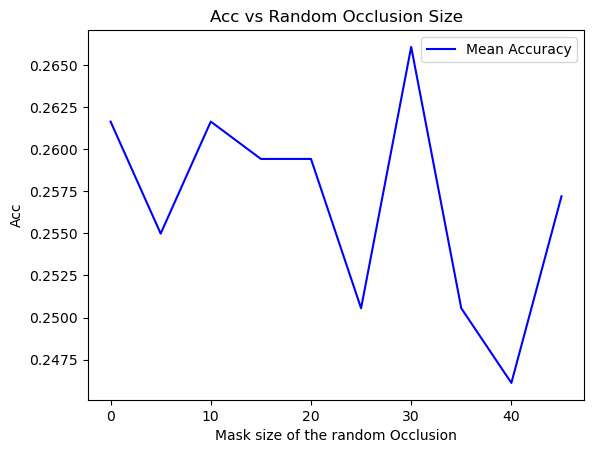

In [22]:
#Test the accuracy with test data after adding random occlusion
acc_occlusion = []

occlusion_size = [ 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

for size in occlusion_size:
    
    valid_X_list = []
    valid_y_list = []

    for img in valid_img_cls.keys():
        img_data = skimage.io.imread(img)

        r,c,_ = img_data.shape
        row_start = random.randint(0,r - size)
        column_start = random.randint(0,c - size)

        # set occlusion region to black with pixel value of (0,0,0) in RGB channel
        for i in range(row_start, row_start + size - 1):
            for j in range(column_start, column_start + size - 1):
                img_data[i][j][:] = 0

        resized_img = skimage.transform.resize(img_data, hog_img_size)
        valid_X_list.append(get_hog(resized_img))
        valid_y_list.append(valid_img_cls[img])

    X_valid = np.vstack(valid_X_list)
    y_valid = np.array(valid_y_list)

    y_pred = svm_model.predict(X_valid)
    acc_occlusion.append(sklearn.metrics.accuracy_score(y_valid, y_pred))

plt.figure(1)
plt.title("Acc vs Random Occlusion Size")
plt.xlabel('Mask size of the random Occlusion')
plt.ylabel('Acc')
plt.plot(occlusion_size,acc_occlusion, color = 'b', label="Mean Accuracy")
plt.legend()
plt.savefig('svm_occlusion.jpg')
plt.show()

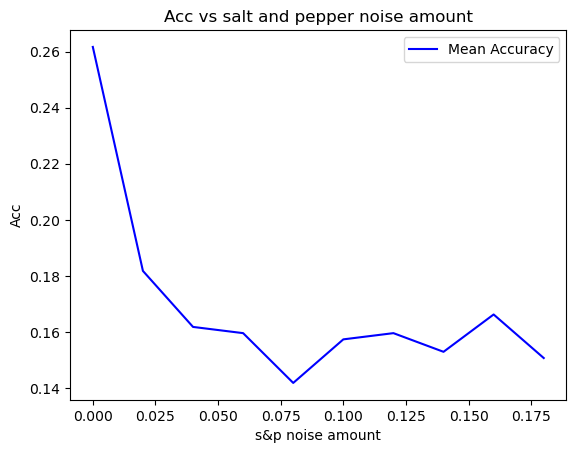

In [21]:
#Test the accuracy with test data after adding salt and pepper pixel noise
acc_sp = []

amounts = [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18]

for a in amounts:
    
    valid_X_list = []
    valid_y_list = []

    for img in valid_img_cls.keys():
        img_data = skimage.io.imread(img)
        
        img_sp = random_noise(img_data, mode='s&p',amount=a, clip=True)

        resized_img = skimage.transform.resize(img_sp*255, hog_img_size)
        valid_X_list.append(get_hog(resized_img))
        valid_y_list.append(valid_img_cls[img])

    X_valid = np.vstack(valid_X_list)
    y_valid = np.array(valid_y_list)

    y_pred = svm_model.predict(X_valid)
    acc_sp.append(sklearn.metrics.accuracy_score(y_valid, y_pred))

plt.figure(1)
plt.title("Acc vs salt and pepper noise amount")
plt.xlabel('s&p noise amount')
plt.ylabel('Acc')
plt.plot(amounts,acc_sp,color = 'b', label="Mean Accuracy")
plt.legend()
plt.savefig('svm_sp.jpg')
plt.show()